In [705]:
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [706]:
data=pd.read_csv('train.csv')

In [707]:
data.columns
pd.options.display.max_columns = 999

In [708]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [709]:
data.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [710]:
data.isnull().sum()[25:60]

MasVnrType        8
MasVnrArea        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinSF1        0
BsmtFinType2     38
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
FireplaceQu     690
GarageType       81
GarageYrBlt      81
dtype: int64

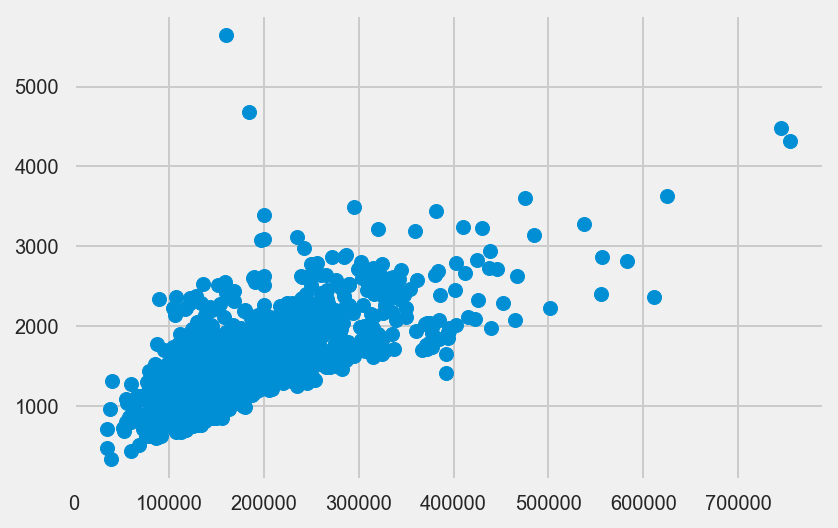

In [711]:
plt.scatter(data['SalePrice'],data['GrLivArea'])

In [712]:
data.shape

(1460, 81)

In [713]:
data = data.drop(data.GrLivArea>4000)

In [714]:
data.shape

(1458, 81)

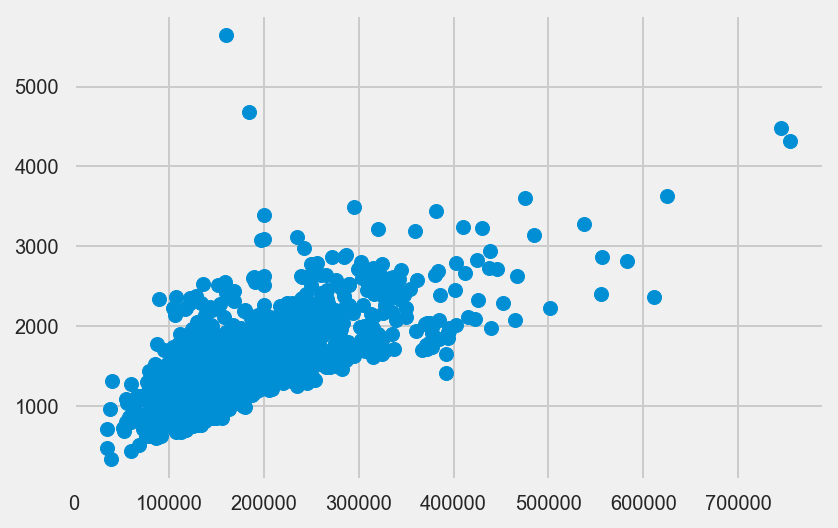

In [715]:
plt.scatter(data['SalePrice'],data['GrLivArea'])

In [716]:
#per recommendation by the data's author, let's remove the outliers above 4000sqft
data=data.loc[data.GrLivArea<4000,:]

In [717]:
data.shape

(1454, 81)

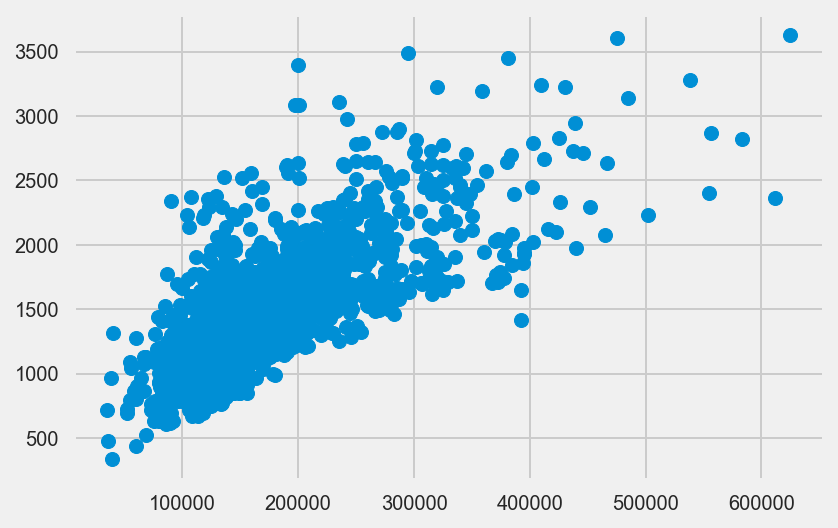

In [718]:
plt.scatter(data['SalePrice'],data['GrLivArea'])

In [719]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000


In [720]:
#20 continuous variables:
continuous=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal']
#did not include: 'BsmtFinSF2','LowQualFinSF','PoolArea' due to low correlation

#14 discrete variables:
discrete=['GarageYrBlt','YearBuilt', 'YearRemodAdd', 'BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars']
#did not include: 'BsmtHalfBath', 'MoSold','YrSold'

#2 ordinal variables:
ordinal=['OverallQual','OverallCond']

#43 categorical variables:
nominal=['LotShape','Utilities','LandSlope','MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','GarageType','MiscFeature','SaleType','SaleCondition','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']
#NOTE: MiscFeature and MiscVal are related!  Value of that feature!


In [721]:
#re-order the dataframe
target='SalePrice'
features=data[continuous+discrete+ordinal+nominal].copy()
features.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,GarageYrBlt,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,OverallQual,OverallCond,LotShape,Utilities,LandSlope,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
2,68.0,11250,162.0,486,434,920,920,866,1786,608,0,42,0,0,0,0,2001.0,2001,2002,1,2,1,3,1,6,1,2,7,5,IR1,AllPub,Gtl,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN
3,60.0,9550,0.0,216,540,756,961,756,1717,642,0,35,272,0,0,0,1998.0,1915,1970,1,1,0,3,1,7,1,3,7,5,IR1,AllPub,Gtl,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN
4,84.0,14260,350.0,655,490,1145,1145,1053,2198,836,192,84,0,0,0,0,2000.0,2000,2000,1,2,1,4,1,9,1,3,8,5,IR1,AllPub,Gtl,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN
5,85.0,14115,0.0,732,64,796,796,566,1362,480,40,30,0,320,0,700,1993.0,1993,1995,1,1,1,1,1,5,0,2,5,5,IR1,AllPub,Gtl,50,RL,Pave,NaN,Lvl,Inside,Mitchel,Norm,Norm,1Fam,1.5Fin,Gable,CompShg,VinylSd,VinylSd,None,Wood,GasA,Y,Attchd,Shed,WD,Normal,TA,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,TA,Typ,NaN,Unf,TA,TA,Y,NaN,MnPrv
6,75.0,10084,186.0,1369,317,1686,1694,0,1694,636,255,57,0,0,0,0,2004.0,2004,2005,1,2,0,3,1,7,1,2,8,5,Reg,AllPub,Gtl,20,RL,Pave,NaN,Lvl,Inside,Somerst,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,Stone,PConc,GasA,Y,Attchd,NaN,WD,Normal,Gd,TA,Ex,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,Gd,RFn,TA,TA,Y,NaN,NaN


In [722]:
#now lets find variables which vary linearly with sales price:

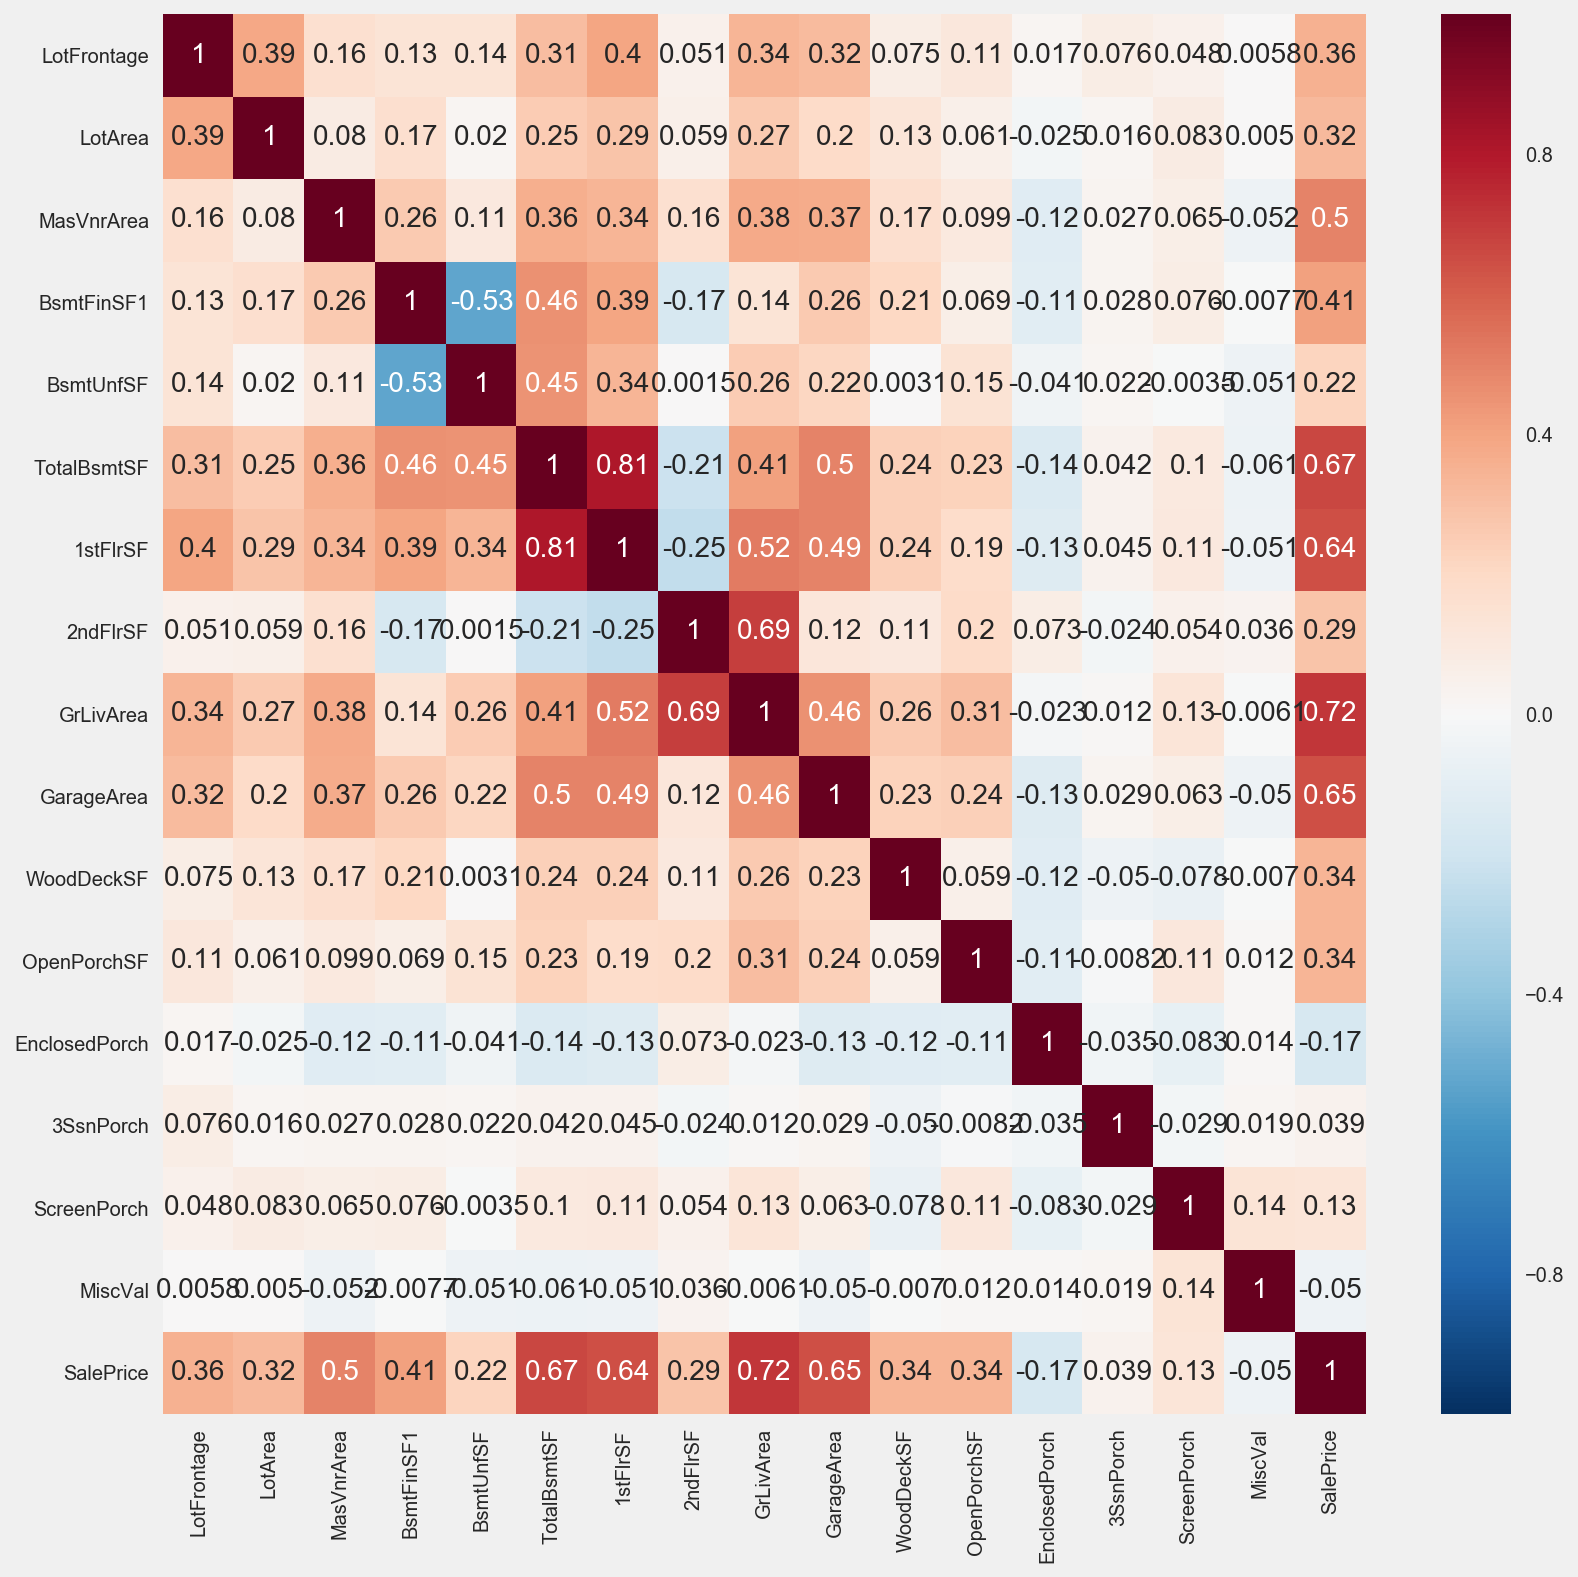

In [723]:
plt.figure(figsize=(12,12))
sns.heatmap(data[continuous+[target]].dropna().corr(), annot=True)

In [724]:
features[continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 2 to 1459
Data columns (total 16 columns):
LotFrontage      1195 non-null float64
LotArea          1454 non-null int64
MasVnrArea       1446 non-null float64
BsmtFinSF1       1454 non-null int64
BsmtUnfSF        1454 non-null int64
TotalBsmtSF      1454 non-null int64
1stFlrSF         1454 non-null int64
2ndFlrSF         1454 non-null int64
GrLivArea        1454 non-null int64
GarageArea       1454 non-null int64
WoodDeckSF       1454 non-null int64
OpenPorchSF      1454 non-null int64
EnclosedPorch    1454 non-null int64
3SsnPorch        1454 non-null int64
ScreenPorch      1454 non-null int64
MiscVal          1454 non-null int64
dtypes: float64(2), int64(14)
memory usage: 193.1 KB


In [725]:
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

In [726]:
target=['SalePrice']

In [727]:
features[discrete].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 2 to 1459
Data columns (total 11 columns):
GarageYrBlt     1373 non-null float64
YearBuilt       1454 non-null int64
YearRemodAdd    1454 non-null int64
BsmtFullBath    1454 non-null int64
FullBath        1454 non-null int64
HalfBath        1454 non-null int64
BedroomAbvGr    1454 non-null int64
KitchenAbvGr    1454 non-null int64
TotRmsAbvGrd    1454 non-null int64
Fireplaces      1454 non-null int64
GarageCars      1454 non-null int64
dtypes: float64(1), int64(10)
memory usage: 136.3 KB


In [728]:
features['GarageYrBlt'].fillna(features['YearBuilt'], inplace=True)

In [729]:
features.loc[features.MasVnrType.isnull(),['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [730]:
features['MasVnrType']=features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

In [731]:
features.loc[features.MasVnrArea.isnull(),['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,None
529,NaN,None
650,NaN,None
936,NaN,None
973,NaN,None
977,NaN,None
1243,NaN,None
1278,NaN,None


In [732]:
features['MasVnrArea'].mode()[0]

0.0

In [733]:
features['MasVnrArea']=features['MasVnrArea'].fillna(features['MasVnrArea'].mode()[0])

In [734]:
features[continuous].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 2 to 1459
Data columns (total 16 columns):
LotFrontage      1454 non-null float64
LotArea          1454 non-null int64
MasVnrArea       1454 non-null float64
BsmtFinSF1       1454 non-null int64
BsmtUnfSF        1454 non-null int64
TotalBsmtSF      1454 non-null int64
1stFlrSF         1454 non-null int64
2ndFlrSF         1454 non-null int64
GrLivArea        1454 non-null int64
GarageArea       1454 non-null int64
WoodDeckSF       1454 non-null int64
OpenPorchSF      1454 non-null int64
EnclosedPorch    1454 non-null int64
3SsnPorch        1454 non-null int64
ScreenPorch      1454 non-null int64
MiscVal          1454 non-null int64
dtypes: float64(2), int64(14)
memory usage: 193.1 KB


In [735]:
features[ordinal].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 2 to 1459
Data columns (total 2 columns):
OverallQual    1454 non-null int64
OverallCond    1454 non-null int64
dtypes: int64(2)
memory usage: 34.1 KB


In [736]:
for column in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    features[column]=features[column].fillna('NoBasement')
for column in ['GarageFinish','GarageQual','GarageCond']:
    features[column]=features[column].fillna('NoGarage')
for column in ['Alley','GarageType','MiscFeature']:
    features[column]=features[column].fillna('AintGotIt')

In [737]:
features['FireplaceQu']=features['FireplaceQu'].fillna('NoFireplace')

In [738]:
features['Fence']=features['Fence'].fillna('NoFence')

In [739]:
features[nominal].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 2 to 1459
Data columns (total 44 columns):
LotShape         1454 non-null object
Utilities        1454 non-null object
LandSlope        1454 non-null object
MSSubClass       1454 non-null int64
MSZoning         1454 non-null object
Street           1454 non-null object
Alley            1454 non-null object
LandContour      1454 non-null object
LotConfig        1454 non-null object
Neighborhood     1454 non-null object
Condition1       1454 non-null object
Condition2       1454 non-null object
BldgType         1454 non-null object
HouseStyle       1454 non-null object
RoofStyle        1454 non-null object
RoofMatl         1454 non-null object
Exterior1st      1454 non-null object
Exterior2nd      1454 non-null object
MasVnrType       1454 non-null object
Foundation       1454 non-null object
Heating          1454 non-null object
CentralAir       1454 non-null object
GarageType       1454 non-null object
MiscFeature      145

In [740]:
features['Electrical']=features['Electrical'].fillna(features['Electrical'].mode()[0])

In [741]:
features['PoolQC']=features['PoolQC'].fillna('NoPool')

In [742]:
features=pd.get_dummies(features,columns=nominal)

In [743]:
features.shape

(1454, 309)

In [744]:
features.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,GarageYrBlt,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,OverallQual,OverallCond,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,Utilities_AllPub,Utilities_NoSeWa,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_AintGotIt,Alley_Grvl,Alley_Pave,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,GarageType_2Types,GarageType_AintGotIt,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,MiscFeature_AintGotIt,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NoBasement,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_AL

In [745]:
y=features.columns.tolist()
y

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'GarageYrBlt',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'OverallQual',
 'OverallCond',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'MSSubClass_20',
 'MSSubClass_30',
 'MSSubClass_40',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_70',
 'MSSubClass_75',
 'MSSubClass_80',
 'MSSubClass_85',
 'MSSubClass_90',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSSubClass_190',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'Alley_

In [746]:
len(y)

309

In [747]:
train_features=features.columns.tolist()
mod_train_features=[x for x in train_features if x not in ['Utilities_NoSeWa',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'MiscFeature_TenC',
 'Electrical_Mix',
 'GarageQual_Ex',
 'PoolQC_Fa','MSSubClass_150']]
len(mod_train_features)

292

In [748]:
X=features[mod_train_features]
y=data[target]

In [749]:
from sklearn.preprocessing import StandardScaler

In [750]:
ss=StandardScaler()

In [751]:
Xstd=ss.fit_transform(X)

In [752]:
from sklearn.linear_model import LinearRegression

In [753]:
from sklearn.model_selection import KFold, GridSearchCV

In [754]:
#first with basic linear model, no lasso, no params
params= {
    #'alpha': np.linspace(1000,2000,15)
}
linstd=LinearRegression()
kf=KFold(n_splits=10,shuffle=True, random_state=1986)
gs=GridSearchCV(linstd, param_grid=params, cv=kf, scoring='r2')
gs.fit(Xstd, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1986, shuffle=True),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [755]:
gs.best_score_

-1.1966724656857009e+23

In [756]:
from sklearn.linear_model import Lasso

In [757]:
#now lets try some lasso!
params= {
    'alpha': np.linspace(300,1000,20)
}
lasso=Lasso()
kf=KFold(n_splits=10,shuffle=True, random_state=1986)
gs=GridSearchCV(lasso, param_grid=params, cv=kf, scoring='r2')
gs.fit(Xstd, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1986, shuffle=True),
       error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  300.     ,   336.84211,   373.68421,   410.52632,   447.36842,
         484.21053,   521.05263,   557.89474,   594.73684,   631.57895,
         668.42105,   705.26316,   742.10526,   778.94737,   815.78947,
         852.63158,   889.47368,   926.31579,   963.15789,  1000.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [758]:
gs.best_score_

0.90986558844844878

In [759]:
gs.best_params_

{'alpha': 410.5263157894737}

In [760]:
test=pd.read_csv('test.csv')

In [761]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [762]:
test.shape

(1459, 80)

In [763]:
#re-order the dataframe
features=test[continuous+discrete+ordinal+nominal].copy()
features.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,GarageYrBlt,YearBuilt,YearRemodAdd,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,OverallQual,OverallCond,LotShape,Utilities,LandSlope,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,80.0,11622,0.0,468.0,270.0,882.0,896,0,896,730.0,140,0,0,0,120,0,1961.0,1961,1961,0.0,1,0,2,1,5,0,1.0,5,6,Reg,AllPub,Gtl,20,RH,Pave,NaN,Lvl,Inside,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,TA,TA,TA,TA,No,Rec,LwQ,TA,SBrkr,TA,Typ,NaN,Unf,TA,TA,Y,NaN,MnPrv
1,81.0,14267,108.0,923.0,406.0,1329.0,1329,0,1329,312.0,393,36,0,0,0,12500,1958.0,1958,1958,0.0,1,1,3,1,6,0,1.0,6,6,IR1,AllPub,Gtl,20,RL,Pave,NaN,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,GasA,Y,Attchd,Gar2,WD,Normal,TA,TA,TA,TA,No,ALQ,Unf,TA,SBrkr,Gd,Typ,NaN,Unf,TA,TA,Y,NaN,NaN
2,74.0,13830,0.0,791.0,137.0,928.0,928,701,1629,482.0,212,34,0,0,0,0,1997.0,1997,1998,0.0,2,1,3,1,6,1,2.0,5,5,IR1,AllPub,Gtl,60,RL,Pave,NaN,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,Attchd,NaN,WD,Normal,TA,TA,Gd,TA,No,GLQ,Unf,Gd,SBrkr,TA,Typ,TA,Fin,TA,TA,Y,NaN,MnPrv
3,78.0,9978,20.0,602.0,324.0,926.0,926,678,1604,470.0,360,36,0,0,0,0,1998.0,1998,1998,0.0,2,1,3,1,7,1,2.0,6,6,IR1,AllPub,Gtl,60,RL,Pave,NaN,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,TA,TA,TA,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,Gd,Fin,TA,TA,Y,NaN,NaN
4,43.0,5005,0.0,263.0,1017.0,1280.0,1280,0,1280,506.0,0,82,0,0,144,0,1992.0,1992,1992,0.0,2,0,2,1,5,0,2.0,8,5,IR1,AllPub,Gtl,120,RL,Pave,NaN,HLS,Inside,StoneBr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,HdBoard,HdBoard,None,PConc,GasA,Y,Attchd,NaN,WD,Normal,Gd,TA,Gd,TA,No,ALQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN


In [764]:
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

In [765]:
features['GarageYrBlt'].fillna(features['YearBuilt'], inplace=True)

In [766]:
features['MasVnrType']=features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['MasVnrArea']=features['MasVnrArea'].fillna(features['MasVnrArea'].mode()[0])

In [767]:
for column in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    features[column]=features[column].fillna('NoBasement')
for column in ['GarageFinish','GarageQual','GarageCond']:
    features[column]=features[column].fillna('NoGarage')
for column in ['Alley','GarageType','MiscFeature']:
    features[column]=features[column].fillna('AintGotIt')

In [768]:
features['FireplaceQu']=features['FireplaceQu'].fillna('NoFireplace')
features['Fence']=features['Fence'].fillna('NoFence')
features['Electrical']=features['Electrical'].fillna(features['Electrical'].mode()[0])
features['PoolQC']=features['PoolQC'].fillna('NoPool')

In [769]:
#these are new transformations! weren't required in the test set!
features['BsmtFinSF1']=features['BsmtFinSF1'].fillna(0)
features['BsmtUnfSF']=features['BsmtUnfSF'].fillna(0)
features['TotalBsmtSF']=features['TotalBsmtSF'].fillna(0)
features['GarageArea']=features['GarageArea'].fillna(0)

In [770]:
features[discrete].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
GarageYrBlt     1459 non-null float64
YearBuilt       1459 non-null int64
YearRemodAdd    1459 non-null int64
BsmtFullBath    1457 non-null float64
FullBath        1459 non-null int64
HalfBath        1459 non-null int64
BedroomAbvGr    1459 non-null int64
KitchenAbvGr    1459 non-null int64
TotRmsAbvGrd    1459 non-null int64
Fireplaces      1459 non-null int64
GarageCars      1458 non-null float64
dtypes: float64(3), int64(8)
memory usage: 125.5 KB


In [771]:
features['BsmtFullBath']=features['BsmtFullBath'].fillna(0)
#garage type is detached!  yet evaluations are 'No Garage!'
features['GarageCars']=features['GarageCars'].fillna(0)

In [772]:
features[nominal].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 44 columns):
LotShape         1459 non-null object
Utilities        1457 non-null object
LandSlope        1459 non-null object
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
Street           1459 non-null object
Alley            1459 non-null object
LandContour      1459 non-null object
LotConfig        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-null object
Exterior2nd      1458 non-null object
MasVnrType       1459 non-null object
Foundation       1459 non-null object
Heating          1459 non-null object
CentralAir       1459 non-null object
GarageType       1459 non-null object
MiscFeature      145

In [773]:
features['Utilities']=features['Utilities'].fillna(features['Utilities'].mode()[0])
features['MSZoning']=features['MSZoning'].fillna(features['MSZoning'].mode()[0])
features['Exterior1st']=features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd']=features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType']=features['SaleType'].fillna(features['SaleType'].mode()[0])
features['KitchenQual']=features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['Functional']=features['Functional'].fillna(features['Functional'].mode()[0])

In [774]:
features=pd.get_dummies(features,columns=nominal)

In [775]:
x=features.columns.tolist()
len(x)

293

In [776]:
features.drop('MSSubClass_150',inplace=True, axis=1)

In [777]:
features.shape

(1459, 292)

In [778]:
Xteststd=ss.transform(features)

In [779]:
pred = gs.predict(Xteststd)

In [780]:
test['SalePrice']=pred

In [781]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,119052.693124
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,163316.379461
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,184907.063181
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,194874.691667
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,207712.276348


In [782]:
test[['Id','SalePrice']].to_csv('result.csv',index=False)